In [1]:
import sys
import os
import yaml
import numpy as np
import pandas
import pathlib
import time
import xarray
from datetime import date
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import matplotlib as mpl
import cmocean as cm

sys.path.insert(1, '../scripts/')
from ssm_utils import get_nearest_node

In [2]:
def running_avg(ts1d, window=24):
    ts1d_24h_avg = []
    i = 0
    while i < (len(ts1d)):
        if i < (len(ts1d)-window):
            ts1d_avg=ts1d[i:i+window].mean()
        else:
            ts1d_avg=np.NaN
        ts1d_24h_avg.append(ts1d_avg)
        i+=1   
    return ts1d_24h_avg

In [3]:
with open('../etc/SSM_config_whidbey.yaml', 'r') as file:
    ssm = yaml.safe_load(file)
    # get shapefile path    
    shp = ssm['paths']['shapefile']

# get node_ids to use in timeseries graphics
locations=['Bellingham Bay','Whidbey (Port Susan)','Whidbey (Oak Harbor)']
lats=[48.724, 48.1912, 48.2443]
lons=[-122.576,-122.4273,-122.6291]
[node_ids, indices, x_locs, y_locs]=get_nearest_node(shp,lats,lons)

mpl.rc('font', size=11)
# some of the following may be repetetive but can also be set relative to the font value above 
#    (eg "xx-small, x-small,small, medium, large, x-large, xx-large, larger, or smaller"; see link above for details)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('legend', fontsize=12)
mpl.rc('axes', titlesize=16)
mpl.rc('axes', labelsize=12)
mpl.rc('figure', titlesize=16)
mpl.rc('text', usetex=False)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

# Define dimension sizes and load shapefile
gdf = gpd.read_file(shp)
gdf = gdf.rename(columns={'region_inf':'Regions'})
regions = gdf[['node_id','Regions']].groupby(
    'Regions').count().index.to_list()
regions.remove('Other')

In [4]:
ssm['siglev_diff']

[3.2, 5.7, 7.5, 8.9, 10.1, 11.1, 12.1, 13.0, 13.8, 14.6]

In [5]:
node_ids

[6367, 11350, 8668]

In [6]:
# load sediment file 
case=[
    'base',
    'ref'
]
paths_sed = [
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/ssm_output_sediments_WQM.nc',
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/ssm_output_sediments_WQM_REF.nc'
]
paths_NPP =[
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/ssm_output_NPP_WQM.nc',
    '/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/SalishSeaModel-analysis/SSM_model_output/ssm_output_NPP_WQM_REF.nc'
    
]
NPP_2d={} # time
NPP_1d={} # Total, net primary productivity gC/m2
node_id = node_ids[0]
# get timeseries of NPP at selected nodes
for idx,path in enumerate(paths_NPP):
    ds_npp = xarray.open_dataset(path,engine='netcdf4')
    NPP_2d[case[idx]]={}
    NPP_1d[case[idx]]={}
    for node_id in node_ids:
        NPP_2d[case[idx]][f'{node_id}'] = ds_npp['netPP'][:,:,node_id-1]
        NPP_1d[case[idx]][f'{node_id}'] = NPP_2d[case[idx]][f'{node_id}'].sum(axis=1) # straight sum OK b/c the value in each level is depth integrated gC/m2 (check!)
        print(case[idx],f'{NPP_2d[case[idx]][f"{node_id}"].shape}', node_id)    

base (8784, 10) 6367
base (8784, 10) 11350
base (8784, 10) 8668
ref (8784, 10) 6367
ref (8784, 10) 11350
ref (8784, 10) 8668


In [7]:
paths=[
    '/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/wqm_baseline/ssm_output.nc',
    '/mmfs1/gscratch/ssmc/USRS/PSI/Sukyong/kingcounty/wqm_reference/ssm_output.nc'
]

NO_2d_diff={}
NO_1d_diff={}
buoyancy={}
NO_2d={}
sal_2d={}
buoyancy={}

for idx,path in enumerate(paths):
    NO_2d[case[idx]]={}
    sal_2d[case[idx]]={}

    ds = xarray.open_dataset(path,engine='netcdf4')
    for node_id in node_ids:
        NO_2d[case[idx]][f'{node_id}'] = ds['NO3'][:,:,node_id-1]+ds['NH4'][:,:,node_id-1]
        sal_2d[case[idx]][f'{node_id}'] = ds['salinity'][:,:,node_id-1]

for node_id in node_ids: 
    # difference in nitrogen between base and reference cases
    NO_2d_diff[f'{node_id}'] = NO_2d['base'][f'{node_id}']-NO_2d['ref'][f'{node_id}']
    # vertical difference in salinity
    buoyancy[f'{node_id}']=sal_2d['base'][f'{node_id}'][:,-1] - sal_2d['base'][f'{node_id}'][:,0]

In [8]:
NO_sum={}
for node_id in node_ids: 
    # difference in nitrogen between base and reference cases
    NO_sum[f'{node_id}'] = NO_2d_diff[f'{node_id}'].sum(axis=1)

In [9]:
# create date vector
dti = pandas.date_range("2014-01-01", periods=24*366, freq="H")
dti.shape

(8784,)

# Smooth timeseries

In [10]:
NPP_1d['diff']={}
NPP_1d_24h={}
buoyancy_24h={}
NO3_diff_24h={}

case_1d=['base','ref','diff']
for node_id in node_ids:
    print(node_id)
    NPP_1d['diff'][f'{node_id}'] = NPP_1d['base'][f'{node_id}'] - NPP_1d['ref'][f'{node_id}']
    # running avg of baseline scenario
    buoyancy_24h[f'{node_id}']=running_avg(buoyancy[f'{node_id}'], window=24)
    # running average of the baseline-reference difference in nutrient loading
    NO3_diff_24h[f'{node_id}']=running_avg(NO_2d_diff[f'{node_id}'], window=24)
    # running average of NPP for each case at the selected nodes
    
for case_name in case_1d:
    NPP_1d_24h[case_name] = {}
    for node_id in node_ids:
        NPP_1d_24h[case_name][f'{node_id}']=running_avg(NPP_1d[case_name][f'{node_id}'], window=24)
        

6367
11350
8668


In [11]:
[*NPP_1d['diff']]

['6367', '11350', '8668']

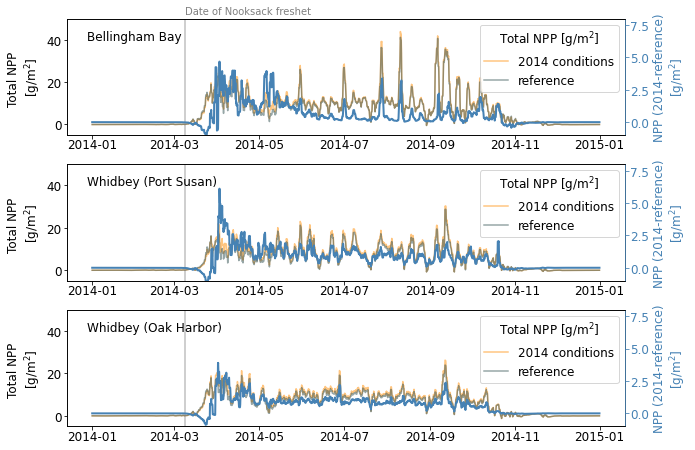

In [17]:
fig, axs = plt.subplots(3,1, figsize = (10,5*3/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1,1,1], 
        'wspace': 0.25,
        'hspace': 0.25})
for idx,node_id in enumerate(node_ids):
    axs[idx].plot(dti,NPP_1d_24h['base'][f'{node_id}'], color='darkorange', label='2014 conditions',alpha=0.5)
    axs[idx].plot(dti,NPP_1d_24h['ref'][f'{node_id}'], color='darkslategrey', label='reference',alpha=0.5)
    
    axs_RHS = axs[idx].twinx()
    diff_line=axs_RHS.plot(
        dti, NPP_1d_24h['diff'][f'{node_id}'], lw=2,color='steelblue', label='difference'
    )
    axs_RHS.set_ylim(-1,8)
    # NPP axis and label
    axs_RHS.set_ylabel('NPP (2014-reference)\n[g/m$^2$]',color='steelblue')
    axs_RHS.tick_params(axis='y', color='steelblue', labelcolor='steelblue')
    axs_RHS.spines['right'].set_color('steelblue')

    #axs[idx].plot(dti,NPP_1d_24h['diff'][f'{node_id}'], color='darkmagenta', label='difference')
    #plot date of nooksack freshet
    axs[idx].plot(
        [pandas.Timestamp("2014-03-09"), pandas.Timestamp("2014-03-09")],
        [-5, 50],
        color='grey',
        alpha=0.5
    )
    if idx==0:
        axs[idx].text(pandas.Timestamp("2014-03-09"),52,'Date of Nooksack freshet', color='grey')
    axs[idx].legend(loc=1, title=f'Total NPP [g/m$^2$]')
    axs[idx].text(pandas.Timestamp("2013-12-28"),40,f'{locations[idx]}', fontsize=12)
    axs[idx].set_ylabel('Total NPP \n[g/m$^2$]')
    axs[idx].set_ylim(-5,50)
plt.savefig(pathlib.Path(ssm['paths']['graphics'])/f'3panel_NPP_3locations.png',
            bbox_inches='tight',format='png')
plt.show()    

# Take aways:
- In all three locations, NPP peaks in Sept (and August in B.Bay)
- In all three locations, the biggest difference in NPP between the 2014 and reference cases is in April

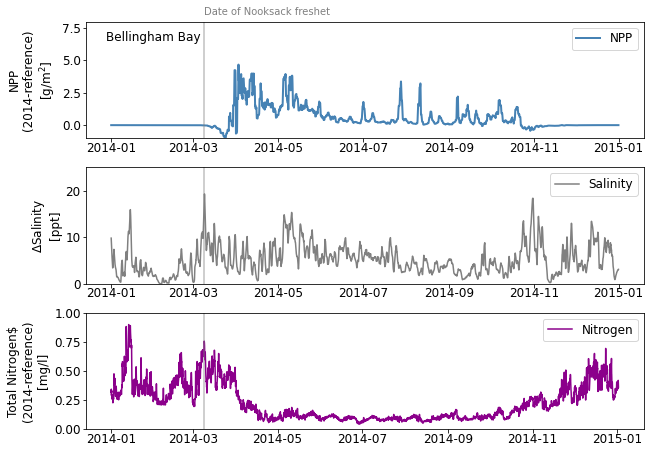

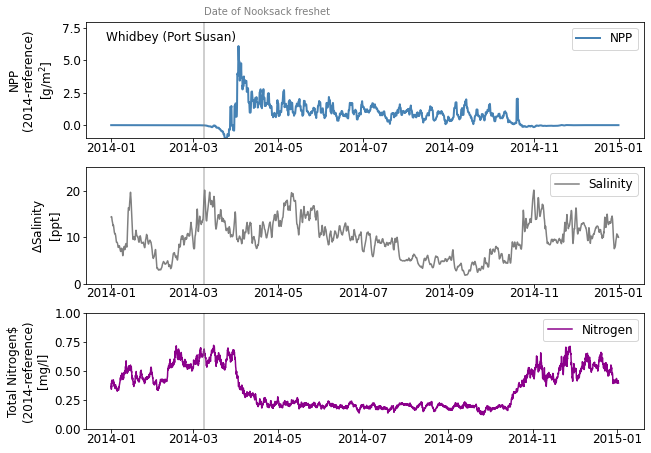

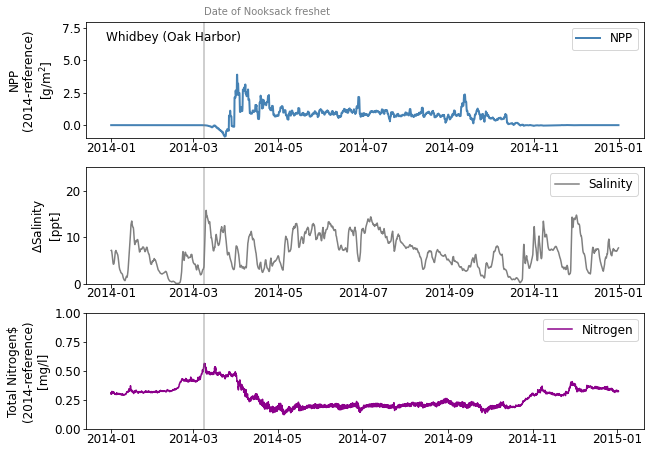

In [13]:
legend_titles=['NPP','Salinity','Nitrogen']
for idx,node_id in enumerate(node_ids):
    fig, axs = plt.subplots(3,1, figsize = (10,5*3/2),
    gridspec_kw={
       'width_ratios': [1],
       'height_ratios': [1,1,1], 
        'wspace': 0.25,
        'hspace': 0.25})
    
    #NPP
    axs[0].plot(
        dti, NPP_1d_24h['diff'][f'{node_id}'], lw=2, color='steelblue', label=f'{legend_titles[0]}'
    )
    axs[0].set_ylabel('NPP\n(2014-reference)\n[g/m$^2$]',)
    axs[0].set_ylim(-1,8)
    axs[0].text(pandas.Timestamp("2013-12-28"),6.5, f'{locations[idx]}', fontsize=12)
    
    # Vertical salinity difference
    axs[1].plot(dti,buoyancy_24h[f'{node_id}'], color='grey', label=f'{legend_titles[1]}')
    axs[1].set_ylabel('$\Delta$Salinity\n[ppt]')
    axs[1].set_ylim(0,25)
    
    axs[2].plot(dti, NO_sum[f'{node_id}'],color='darkmagenta',label=f'{legend_titles[2]}')
    #axs[2].plot(dti, NO3_diff_24h[f'{node_id}'],color='darkmagenta',label='2014-reference')
    axs[2].set_ylabel('Total Nitrogen$\n(2014-reference)\n[mg/l]')
    axs[2].set_ylim(0,1)
    
    for idx_2 in [0,1,2]:
        axs[idx_2].plot(
            [pandas.Timestamp("2014-03-09"), pandas.Timestamp("2014-03-09")],
            [-5, 50],
            color='grey',
            alpha=0.5
        )
        axs[idx_2].legend(loc=1)
    axs[0].text(pandas.Timestamp("2014-03-09"),8.5,'Date of Nooksack freshet', color='grey')
    plt.savefig(pathlib.Path(ssm['paths']['graphics'])/f'3panel_NPP_Sal_N_{locations[idx]}.png',
                bbox_inches='tight',format='png')
    plt.show()    


# Take aways:
- In all three locations, the biggest difference in NPP between the 2014 and reference cases is in April
- Whidbey (Port Susan) has the strongest, overall stratification, the greatest amount of total Nitrogen and the strongest peak in NPP in April
- Some $\Delta$NPP peaks in later summer seem to track with a reduction of $\Delta$Salinity, which suggests vertical mixing as a resupply of Nitrogen (see, e.g., end of June and mid-Sept in Oak Harbor).  Perhaps NPP is light-limited in the early summer and nutrient-limited in the late summer? 
- B. Bay total nitrogen shows some wiggles (~2/month) that may relate to tidal flushing? 
- The initial response of NPP to the spring freshet is greater in the reference scenario than the 2014 scenario (i.e. the values drop own to -1 mg/l difference first before going positive).  Why? 

In [18]:
ssm['paths']['graphics']

'/mmfs1/gscratch/ssmc/USRS/PSI/Rachael/projects/KingCounty/graphics/'